In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.5 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 32781 
    Total predicted counts          : 33265.86
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 7.47 s, sys: 66.3 ms, total: 7.54 s
Wall time: 7.54 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 33357 
    Total predicted counts          : 33342.46
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 32889 
    Total predicted counts          : 33263.86
    Total off counts                : 101672.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_21 

    Total counts                    : 33019 
    Total predicted counts          : 33268.26
    Total off counts                : 101694.00

    Total background counts         : 20338.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_22 

    Total counts                    : 33192 
    Total predicted counts          : 33217.66
    Total off counts                : 101441.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_49 

    Total counts                    : 33620 
    Total predicted counts          : 33231.66
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_50 

    Total counts                    : 32898 
    Total predicted counts          : 33236.06
    Total off counts                : 101533.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_70 

    Total counts                    : 33196 
    Total predicted counts          : 33125.26
    Total off counts                : 100979.00

    Total background counts         : 20195.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_71 

    Total counts                    : 33336 
    Total predicted counts          : 33176.86
    Total off counts                : 101237.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 33266 
    Total predicted counts          : 33205.66
    Total off counts                : 101381.00

    Total background counts         : 20276.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_87 

    Total counts                    : 33248 
    Total predicted counts          : 33293.26
    Total off counts                : 101819.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_115 

    Total counts                    : 33581 
    Total predicted counts          : 33127.06
    Total off counts                : 100988.00

    Total background counts         : 20197.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_116 

    Total counts                    : 32935 
    Total predicted counts          : 33153.66
    Total off counts                : 101121.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_137 

    Total counts                    : 33494 
    Total predicted counts          : 33285.86
    Total off counts                : 101782.00

    Total background counts         : 20356.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_138 

    Total counts                    : 33642 
    Total predicted counts          : 33257.26
    Total off counts                : 101639.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 33170 
    Total predicted counts          : 33254.46
    Total off counts                : 101625.00

    Total background counts         : 20325.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 33291 
    Total predicted counts          : 33271.46
    Total off counts                : 101710.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 33275 
    Total predicted counts          : 33216.86
    Total off counts                : 101437.00

    Total background counts         : 20287.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 33212 
    Total predicted counts          : 33318.06
    Total off counts                : 101943.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_222 

    Total counts                    : 33076 
    Total predicted counts          : 33336.86
    Total off counts                : 102037.00

    Total background counts         : 20407.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_223 

    Total counts                    : 33130 
    Total predicted counts          : 33250.26
    Total off counts                : 101604.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 33439 
    Total predicted counts          : 33226.46
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 33118 
    Total predicted counts          : 33202.66
    Total off counts                : 101366.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_272 

    Total counts                    : 33346 
    Total predicted counts          : 33260.46
    Total off counts                : 101655.00

    Total background counts         : 20331.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_273 

    Total counts                    : 32849 
    Total predicted counts          : 33190.46
    Total off counts                : 101305.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_300 

    Total counts                    : 33167 
    Total predicted counts          : 33238.06
    Total off counts                : 101543.00

    Total background counts         : 20308.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_301 

    Total counts                    : 33468 
    Total predicted counts          : 33353.26
    Total off counts                : 102119.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 32887 
    Total predicted counts          : 33195.26
    Total off counts                : 101329.00

    Total background counts         : 20265.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_325 

    Total counts                    : 33471 
    Total predicted counts          : 33211.06
    Total off counts                : 101408.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_353 

    Total counts                    : 33234 
    Total predicted counts          : 33240.26
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_354 

    Total counts                    : 33317 
    Total predicted counts          : 33230.66
    Total off counts                : 101506.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_380 

    Total counts                    : 33079 
    Total predicted counts          : 33258.26
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_381 

    Total counts                    : 33341 
    Total predicted counts          : 33211.86
    Total off counts                : 101412.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_406 

    Total counts                    : 33249 
    Total predicted counts          : 33318.06
    Total off counts                : 101943.00

    Total background counts         : 20388.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_407 

    Total counts                    : 33466 
    Total predicted counts          : 33348.46
    Total off counts                : 102095.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_434 

    Total counts                    : 33294 
    Total predicted counts          : 33236.86
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_435 

    Total counts                    : 33381 
    Total predicted counts          : 33132.66
    Total off counts                : 101016.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 33381 
    Total predicted counts          : 33372.86
    Total off counts                : 102217.00

    Total background counts         : 20443.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 33623 
    Total predicted counts          : 33276.86
    Total off counts                : 101737.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_473 

    Total counts                    : 33376 
    Total predicted counts          : 33258.06
    Total off counts                : 101643.00

    Total background counts         : 20328.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 33265 
    Total predicted counts          : 33310.66
    Total off counts                : 101906.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_495 

    Total counts                    : 33443 
    Total predicted counts          : 33186.06
    Total off counts                : 101283.00

    Total background counts         : 20256.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 33261 
    Total predicted counts          : 33232.06
    Total off counts                : 101513.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_521 

    Total counts                    : 33507 
    Total predicted counts          : 33217.46
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_522 

    Total counts                    : 33108 
    Total predicted counts          : 33155.66
    Total off counts                : 101131.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_548 

    Total counts                    : 33335 
    Total predicted counts          : 33256.46
    Total off counts                : 101635.00

    Total background counts         : 20327.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_549 

    Total counts                    : 33317 
    Total predicted counts          : 33227.06
    Total off counts                : 101488.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_566 

    Total counts                    : 33243 
    Total predicted counts          : 33224.86
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_567 

    Total counts                    : 33282 
    Total predicted counts          : 33195.46
    Total off counts                : 101330.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_588 

    Total counts                    : 33126 
    Total predicted counts          : 33272.46
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 33234 
    Total predicted counts          : 33268.46
    Total off counts                : 101695.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_619 

    Total counts                    : 33147 
    Total predicted counts          : 33295.86
    Total off counts                : 101832.00

    Total background counts         : 20366.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_620 

    Total counts                    : 33411 
    Total predicted counts          : 33291.46
    Total off counts                : 101810.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_647 

    Total counts                    : 33382 
    Total predicted counts          : 33217.46
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_648 

    Total counts                    : 33284 
    Total predicted counts          : 33265.06
    Total off counts                : 101678.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 33032 
    Total predicted counts          : 33093.26
    Total off counts                : 100819.00

    Total background counts         : 20163.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_665 

    Total counts                    : 33106 
    Total predicted counts          : 33185.26
    Total off counts                : 101279.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_684 

    Total counts                    : 33357 
    Total predicted counts          : 33351.06
    Total off counts                : 102108.00

    Total background counts         : 20421.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_685 

    Total counts                    : 33386 
    Total predicted counts          : 33338.26
    Total off counts                : 102044.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_702 

    Total counts                    : 33109 
    Total predicted counts          : 33229.86
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_703 

    Total counts                    : 33130 
    Total predicted counts          : 33189.46
    Total off counts                : 101300.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_723 

    Total counts                    : 33300 
    Total predicted counts          : 33271.66
    Total off counts                : 101711.00

    Total background counts         : 20342.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_724 

    Total counts                    : 33411 
    Total predicted counts          : 33226.06
    Total off counts                : 101483.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 33297 
    Total predicted counts          : 33200.86
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_754 

    Total counts                    : 33523 
    Total predicted counts          : 33188.46
    Total off counts                : 101295.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_783 

    Total counts                    : 32950 
    Total predicted counts          : 33142.26
    Total off counts                : 101064.00

    Total background counts         : 20212.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_784 

    Total counts                    : 33403 
    Total predicted counts          : 33266.26
    Total off counts                : 101684.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_796 

    Total counts                    : 33005 
    Total predicted counts          : 33140.66
    Total off counts                : 101056.00

    Total background counts         : 20211.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_797 

    Total counts                    : 32970 
    Total predicted counts          : 33272.86
    Total off counts                : 101717.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_823 

    Total counts                    : 33508 
    Total predicted counts          : 33216.26
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_824 

    Total counts                    : 33275 
    Total predicted counts          : 33163.06
    Total off counts                : 101168.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_844 

    Total counts                    : 33112 
    Total predicted counts          : 33188.66
    Total off counts                : 101296.00

    Total background counts         : 20259.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 33301 
    Total predicted counts          : 33284.06
    Total off counts                : 101773.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_864 

    Total counts                    : 33318 
    Total predicted counts          : 33250.26
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_865 

    Total counts                    : 32961 
    Total predicted counts          : 33236.46
    Total off counts                : 101535.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 33504 
    Total predicted counts          : 33224.06
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_896 

    Total counts                    : 33364 
    Total predicted counts          : 33230.06
    Total off counts                : 101503.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_926 

    Total counts                    : 33244 
    Total predicted counts          : 33257.46
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_927 

    Total counts                    : 33222 
    Total predicted counts          : 33103.46
    Total off counts                : 100870.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_950 

    Total counts                    : 33119 
    Total predicted counts          : 33189.66
    Total off counts                : 101301.00

    Total background counts         : 20260.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_951 

    Total counts                    : 33264 
    Total predicted counts          : 33153.26
    Total off counts                : 101119.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_972 

    Total counts                    : 33175 
    Total predicted counts          : 33193.06
    Total off counts                : 101318.00

    Total background counts         : 20263.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_973 

    Total counts                    : 33237 
    Total predicted counts          : 33278.86
    Total off counts                : 101747.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_999 

    Total counts                    : 33119 
    Total predicted counts          : 33241.46
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1000 

    Total counts                    : 33555 
    Total predicted counts          : 33309.66
    Total off counts                : 101901.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1028 

    Total counts                    : 33316 
    Total predicted counts          : 33270.26
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1029 

    Total counts                    : 33225 
    Total predicted counts          : 33268.46
    Total off counts                : 101695.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1058 

    Total counts                    : 33278 
    Total predicted counts          : 33214.66
    Total off counts                : 101426.00

    Total background counts         : 20285.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1059 

    Total counts                    : 33096 
    Total predicted counts          : 33262.66
    Total off counts                : 101666.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1088 

    Total counts                    : 33497 
    Total predicted counts          : 33201.66
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1089 

    Total counts                    : 32973 
    Total predicted counts          : 33136.66
    Total off counts                : 101036.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1120 

    Total counts                    : 33055 
    Total predicted counts          : 33271.26
    Total off counts                : 101709.00

    Total background counts         : 20341.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1121 

    Total counts                    : 33255 
    Total predicted counts          : 33248.86
    Total off counts                : 101597.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1147 

    Total counts                    : 33270 
    Total predicted counts          : 33236.06
    Total off counts                : 101533.00

    Total background counts         : 20306.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1148 

    Total counts                    : 33024 
    Total predicted counts          : 33175.46
    Total off counts                : 101230.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1165 

    Total counts                    : 33391 
    Total predicted counts          : 33190.66
    Total off counts                : 101306.00

    Total background counts         : 20261.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1166 

    Total counts                    : 33124 
    Total predicted counts          : 33272.26
    Total off counts                : 101714.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1198 

    Total counts                    : 33303 
    Total predicted counts          : 33238.66
    Total off counts                : 101546.00

    Total background counts         : 20309.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1199 

    Total counts                    : 33238 
    Total predicted counts          : 33256.66
    Total off counts                : 101636.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1231 

    Total counts                    : 33422 
    Total predicted counts          : 33281.06
    Total off counts                : 101758.00

    Total background counts         : 20351.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1232 

    Total counts                    : 33380 
    Total predicted counts          : 33254.06
    Total off counts                : 101623.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1259 

    Total counts                    : 33473 
    Total predicted counts          : 33207.86
    Total off counts                : 101392.00

    Total background counts         : 20278.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1260 

    Total counts                    : 33427 
    Total predicted counts          : 33228.86
    Total off counts                : 101497.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1285 

    Total counts                    : 33211 
    Total predicted counts          : 33291.26
    Total off counts                : 101809.00

    Total background counts         : 20361.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1286 

    Total counts                    : 33158 
    Total predicted counts          : 33243.86
    Total off counts                : 101572.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1314 

    Total counts                    : 33327 
    Total predicted counts          : 33234.26
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1315 

    Total counts                    : 33078 
    Total predicted counts          : 33141.06
    Total off counts                : 101058.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1344 

    Total counts                    : 33846 
    Total predicted counts          : 33265.26
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1345 

    Total counts                    : 33376 
    Total predicted counts          : 33236.86
    Total off counts                : 101537.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1374 

    Total counts                    : 33256 
    Total predicted counts          : 33240.06
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1375 

    Total counts                    : 33380 
    Total predicted counts          : 33234.46
    Total off counts                : 101525.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1404 

    Total counts                    : 33523 
    Total predicted counts          : 33176.86
    Total off counts                : 101237.00

    Total background counts         : 20247.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1405 

    Total counts                    : 33518 
    Total predicted counts          : 33270.66
    Total off counts                : 101706.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1429 

    Total counts                    : 33259 
    Total predicted counts          : 33201.66
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1430 

    Total counts                    : 32864 
    Total predicted counts          : 33206.86
    Total off counts                : 101387.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1456 

    Total counts                    : 33113 
    Total predicted counts          : 33149.26
    Total off counts                : 101099.00

    Total background counts         : 20219.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1457 

    Total counts                    : 33110 
    Total predicted counts          : 33232.26
    Total off counts                : 101514.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1487 

    Total counts                    : 33342 
    Total predicted counts          : 33220.26
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1488 

    Total counts                    : 33384 
    Total predicted counts          : 33253.86
    Total off counts                : 101622.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1515 

    Total counts                    : 33187 
    Total predicted counts          : 33292.46
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1516 

    Total counts                    : 33613 
    Total predicted counts          : 33391.66
    Total off counts                : 102311.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1547 

    Total counts                    : 33048 
    Total predicted counts          : 33284.66
    Total off counts                : 101776.00

    Total background counts         : 20355.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1548 

    Total counts                    : 33429 
    Total predicted counts          : 33205.06
    Total off counts                : 101378.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1578 

    Total counts                    : 33469 
    Total predicted counts          : 33211.26
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1579 

    Total counts                    : 33199 
    Total predicted counts          : 33313.26
    Total off counts                : 101919.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1608 

    Total counts                    : 33664 
    Total predicted counts          : 33198.26
    Total off counts                : 101344.00

    Total background counts         : 20268.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1609 

    Total counts                    : 33214 
    Total predicted counts          : 33279.86
    Total off counts                : 101752.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1639 

    Total counts                    : 33165 
    Total predicted counts          : 33111.86
    Total off counts                : 100912.00

    Total background counts         : 20182.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1640 

    Total counts                    : 33645 
    Total predicted counts          : 33319.66
    Total off counts                : 101951.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1670 

    Total counts                    : 33010 
    Total predicted counts          : 33218.86
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1671 

    Total counts                    : 33361 
    Total predicted counts          : 33280.26
    Total off counts                : 101754.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1701 

    Total counts                    : 33273 
    Total predicted counts          : 33208.46
    Total off counts                : 101395.00

    Total background counts         : 20279.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1702 

    Total counts                    : 33478 
    Total predicted counts          : 33226.66
    Total off counts                : 101486.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1731 

    Total counts                    : 33572 
    Total predicted counts          : 33205.26
    Total off counts                : 101379.00

    Total background counts         : 20275.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1732 

    Total counts                    : 33124 
    Total predicted counts          : 33266.26
    Total off counts                : 101684.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1761 

    Total counts                    : 33250 
    Total predicted counts          : 33161.46
    Total off counts                : 101160.00

    Total background counts         : 20232.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1762 

    Total counts                    : 33115 
    Total predicted counts          : 33248.26
    Total off counts                : 101594.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1794 

    Total counts                    : 33498 
    Total predicted counts          : 33314.66
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1795 

    Total counts                    : 33265 
    Total predicted counts          : 33239.06
    Total off counts                : 101548.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1823 

    Total counts                    : 33137 
    Total predicted counts          : 33099.46
    Total off counts                : 100850.00

    Total background counts         : 20170.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1824 

    Total counts                    : 32772 
    Total predicted counts          : 33349.26
    Total off counts                : 102099.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1850 

    Total counts                    : 33267 
    Total predicted counts          : 33133.66
    Total off counts                : 101021.00

    Total background counts         : 20204.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1851 

    Total counts                    : 33321 
    Total predicted counts          : 33182.26
    Total off counts                : 101264.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1882 

    Total counts                    : 33173 
    Total predicted counts          : 33302.86
    Total off counts                : 101867.00

    Total background counts         : 20373.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1883 

    Total counts                    : 33156 
    Total predicted counts          : 33235.46
    Total off counts                : 101530.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1910 

    Total counts                    : 33028 
    Total predicted counts          : 33214.26
    Total off counts                : 101424.00

    Total background counts         : 20284.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1911 

    Total counts                    : 33230 
    Total predicted counts          : 33202.66
    Total off counts                : 101366.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1941 

    Total counts                    : 33070 
    Total predicted counts          : 33165.66
    Total off counts                : 101181.00

    Total background counts         : 20236.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1942 

    Total counts                    : 33123 
    Total predicted counts          : 33396.46
    Total off counts                : 102335.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1972 

    Total counts                    : 33056 
    Total predicted counts          : 33257.66
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1973 

    Total counts                    : 33254 
    Total predicted counts          : 33234.46
    Total off counts                : 101525.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

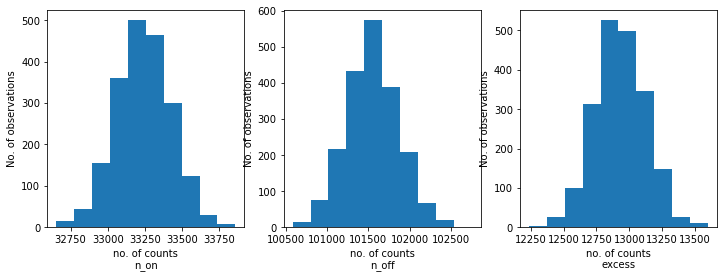

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 6min 45s, sys: 1.29 s, total: 6min 46s
Wall time: 6min 51s


In [15]:
results

[{'index': 2.232538916476606,
  'amplitude': 1.2373518606812286e-12,
  'lambda_': 0.44514007771400643},
 {'index': 2.1921386356870185,
  'amplitude': 1.3405471272444897e-12,
  'lambda_': 0.5539388397471491},
 {'index': 2.2390306532290274,
  'amplitude': 1.2114311723919235e-12,
  'lambda_': 0.481853635003571},
 {'index': 2.2381540033754255,
  'amplitude': 1.2512809290515709e-12,
  'lambda_': 0.5030039142543251},
 {'index': 2.241836083562033,
  'amplitude': 1.2686520335181529e-12,
  'lambda_': 0.5059561427729724},
 {'index': 2.1818599630503877,
  'amplitude': 1.3849873943605872e-12,
  'lambda_': 0.5523709213406991},
 {'index': 2.2361683329909523,
  'amplitude': 1.2748053201934255e-12,
  'lambda_': 0.4974112233182603},
 {'index': 2.2015748888965336,
  'amplitude': 1.3344334689422759e-12,
  'lambda_': 0.5278376715864108},
 {'index': 2.2232129757923187,
  'amplitude': 1.2387241715088374e-12,
  'lambda_': 0.45697540823556376},
 {'index': 2.257772560517059,
  'amplitude': 1.153001391526499e-1

index: 2.219322560824327 += 0.022490503694577214


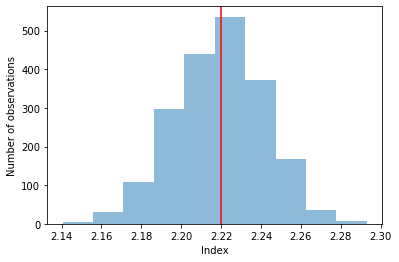

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.292825778177421e-12 += 6.334785419811738e-14


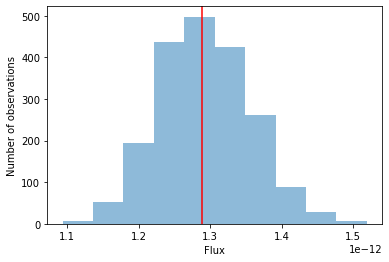

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.5022192826952404 += 0.03704176697035999


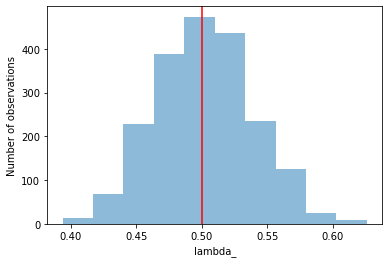

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")